### To Do List
- Sort out issue with soho_polygon <- leeds_polygon from leeds_area (geometry?)
- Check for points within polygon
- Drop points outside of polygon


#### If that does not work:
- calculate BNG to lat-lon
- calculate distance from center
- drop those which are more than 500 meters from the center

- See how many accidents are exact fits after snapping

#### Finally
- Add documentation
- Plot network with time information
- Complete other investigative work for Task B
- Begin and complete Task C

In [147]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import random
import folium
import pyproj
import numpy as np
import requests
import shapely.geometry
import os
import pandas as pd
import glob
from IPython.display import clear_output
from datetime import timedelta
import time
# Some new libraries: they should already
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
import spaghetti
import math

In [90]:
def print_loading_bar(iteration, total, bar_length=50):
    percent = "{:.0%}".format(iteration / total)
    filled_length = int(bar_length * iteration // total)
    bar = "█" * filled_length + "-" * (bar_length - filled_length)

    remaining_time = (time.time() - start_time) * (total - iteration) / iteration if iteration > 0 else 0
    eta = str(timedelta(seconds=int(remaining_time)))
    print(f"\rLoading: [{bar}] {percent} ({iteration}/{total}) ETA: {eta}", end="", flush=True)

In [143]:
def distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance (in meters) between two points on the Earth's surface
    given their latitude and longitude coordinates using the Haversine formula.
    """
    R = 6371000  # radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))

    return R*c

## Task A (spatial networks and planarity):

In this task, you construct and investigate the road network. You are asked to choose an area of roughly 1 square kilometre around the centre of Leeds for your analysis. You should look for an area where a significant number of the recorded road accidents occurred in the area, e.g. 300 or more total across multiple years, and show you have tested this in your report. You only need to consider roads used for driving, not walking paths or private roads (investigate the osmnx documentation for how you might do this filtering). Your report should give the coordinates of the area chosen. You should then answer the following questions:

1.     What are the characteristics of this road network? Include, at least, the spatial diameter of the network, the average street length, node density, intersection density, and edge density.

2.     What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?

3.     Is the network planar? Why/why not?

In [145]:
center_lat = 53.802035
center_lon = -1.537810

In [6]:
center_lat = 53.802035
center_lon = -1.537810
# 53.802035, -1.537810
# 53.785131, -1.549249
# 53.799023, -1.540866
# 53.8008, -1.5491
# 53.800777, -1.538732

# Define the center point of Leeds
leeds_center = (center_lat, center_lon)

# Create the graph for Leeds city center
leeds_graph = ox.graph.graph_from_point(leeds_center, dist=500, dist_type='bbox', network_type='drive')
leeds_bbox = ox.utils_geo.bbox_from_point(leeds_center, dist=500)
leeds_area = ox.project_gdf(leeds_area).unary_union.area

leeds_area


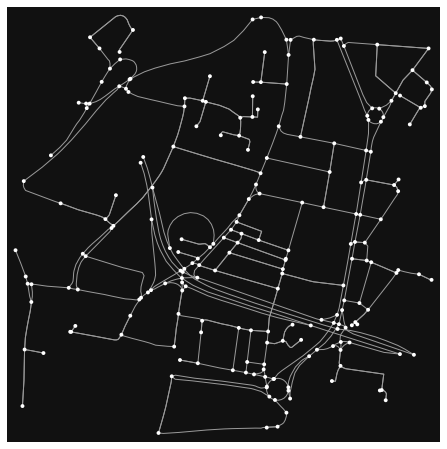

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
ox.plot_graph(leeds_graph)

In [22]:
# graph_project = ox.project_graph(query_place_graph)
ox.plot_graph_folium(leeds_graph)

1.     What are the characteristics of this road network? Include, at least, the spatial diameter of the network, the average street length, node density, intersection density, and edge density.

2.     What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?


In [76]:
# Calculate Basic Stats
basic_stats = ox.stats.basic_stats(leeds_graph, area=leeds_area)

# Spatial Diameter

# Average Street Length
print("Average street length: {}m".format(round(basic_stats["street_length_avg"], 2)))

# Node Density
print("Node density of {} nodes per square km".format(basic_stats["n"]))

# Intersection Density
print("Intersection density of {} intersections per square km".format(basic_stats["intersection_count"]))

# Edge Density
print("Edge density of {} edges per square km".format(basic_stats["edge_density_km"]))

Average street length: 65.49m
Node density of 217 nodes per square km
Intersection density of 190 intersections per square km
Edge density of 24577.693000000014 edges per square km


In [24]:
for m in basic_stats:
    print("{}: {}".format(m, basic_stats[m]))

n: 217
m: 386
k_avg: 3.557603686635945
edge_length_total: 24577.693000000014
edge_length_avg: 63.67277979274615
streets_per_node_avg: 2.8202764976958523
streets_per_node_counts: {0: 0, 1: 27, 2: 12, 3: 151, 4: 27}
streets_per_node_proportions: {0: 0.0, 1: 0.12442396313364056, 2: 0.055299539170506916, 3: 0.695852534562212, 4: 0.12442396313364056}
intersection_count: 190
street_length_total: 18731.113000000005
street_segment_count: 286
street_length_avg: 65.49340209790212
circuity_avg: 1.0303846733857918
self_loop_proportion: 0.0
node_density_km: 217.0
intersection_density_km: 190.0
edge_density_km: 24577.693000000014
street_density_km: 18731.113000000005


In [26]:
is_planar, kuratowski_subgraphs = nx.check_planarity(leeds_graph, counterexample=True)
is_planar

False

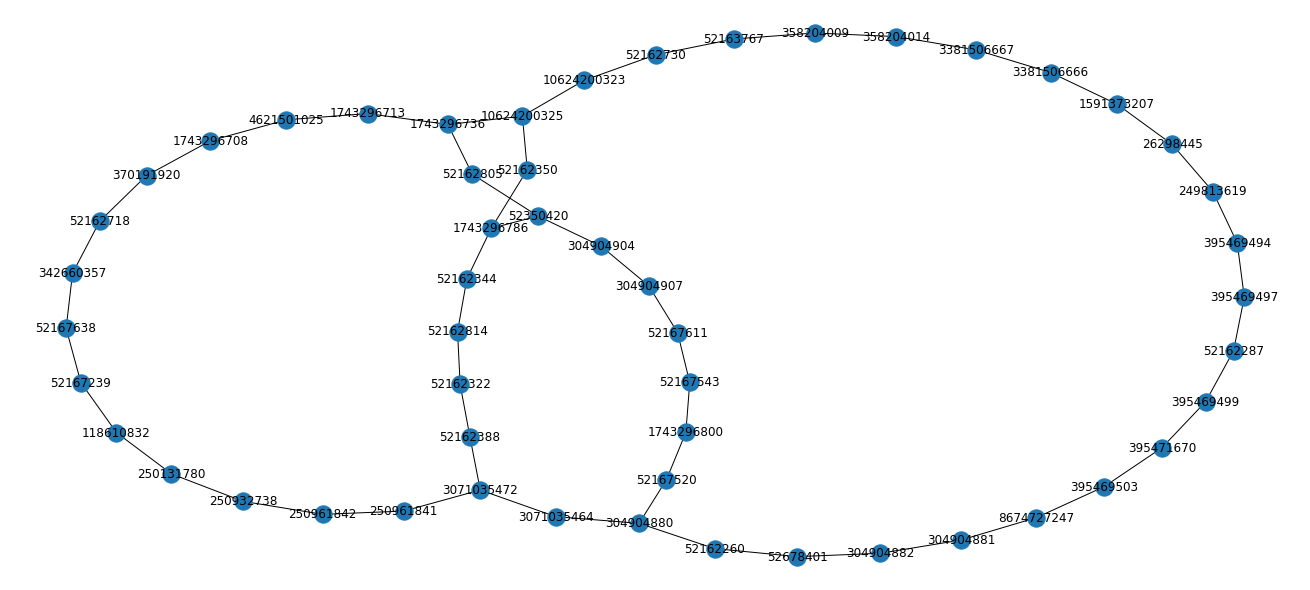

In [27]:
plt.figure(figsize=(18, 8))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, arrowstyle='-|>', with_labels=True)
plt.show()

In [28]:
# get the spatial diameter of the network (longest shortest path between any two nodes)
diameter = ox.extended_stats(leeds_graph).get('diameter')
print("Spatial diameter of the network:", diameter, "meters")

# get the average street length
avg_street_length = ox.basic_stats(leeds_graph).get('avg_edge_length')
print("Average street length:", avg_street_length, "meters")

# get the node density (number of nodes per square kilometer)
node_density = ox.basic_stats(leeds_graph, area=1000000).get('n') / 1000000
print("Node density:", node_density, "nodes per square kilometer")

# get the intersection density (number of intersections per square kilometer)
intersection_density = ox.basic_stats(leeds_graph, area=1000000).get('intersection_count') / 1000000
print("Intersection densiresponse = requests.get("https://nominatim.openstreetmap.org/reverse?lat={}&lon={}&format=json".format(lat, lng))
osm_id_leeds = response.json()["osm_id"]
osm_id_leedsty:", intersection_density, "intersections per square kilometer")

# get the edge density (number of edges per square kilometer)
edge_density = ox.basic_stats(leeds_graph, area=1000000).get('m') / 1000000
print("Edge density:", edge_density, "edges per square kilometer")

# get the average circuitry (ratio of network length to straight-line distance between nodes)
avg_circuitry = ox.basic_stats(leeds_graph).get('circuity_avg')
print("Average circuitry of the network:", avg_circuitry)

if is_planar:
    print("The network is planar.")
else:
    print("The network is not planar.")

/home/k21195339/.local/lib/python3.8/site-packages/osmnx/stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


Spatial diameter of the network: None meters
Average street length: None meters
Node density: 0.000217 nodes per square kilometer
Intersection density: 0.00019 intersections per square kilometer
Edge density: 0.000386 edges per square kilometer
Average circuitry of the network: 1.0303846733857918
The network is not planar.


## Task B (Road Accidents):

In this task, you should investigate the road accidents on the road network.

1.     Plot the distribution of road accidents on your road network and visualise this. Aggregate across multiple years of accident data. You do not need to consider or represent when the accidents happened, only their location; but you are welcome to add information about time if you believe there is something interesting to show.

2.     Investigate whether a high number of accidents on one road correlates with a high number on connecting roads.

3.     Investigate whether accidents happen nearer to intersections or partway along roads. Consider this as asking at what fraction of the road length away from the nearest intersection do accidents typically occur.

For the above, we suggest using the spaghetti library as shown in your lessons. The third question will require investigating the API of the library to find the relevant functions to answer the question.

In [126]:
# Here, I assume that you downloaded or moved the crime data in `../data/crimes/`
CRIMES_DIR = "data"  # then, one subfolder for each YEAR-MONTH
# We will only use the longitude and latitude columns in the data
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing', 'Accident Date']

# We need to load and collate all CSV files into a single dataframe
years_df = [pd.read_csv(csv_file, usecols=USE_COLS, encoding='iso-8859-1') \
                for path, subdir, _ in os.walk(CRIMES_DIR) \
                 for csv_file in glob.glob(os.path.join(path, "*.csv"))]

print("Found {} CSV files in {}".format(len(months_df), CRIMES_DIR))

accidents_df = pd.concat(years_df, axis=0, ignore_index=True)
print("Total no. of accidents loaded: {}".format(len(crimes_df)))

# Some accide do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_accidents = accidents_df.dropna(subset=USE_COLS)
print("Total no. of located crimes filtered: {}".format(len(located_accidents)))

Found 6 CSV files in data
Total no. of accidents loaded: 13851
Total no. of located crimes filtered: 13851


In [127]:
located_accidents

,Grid Ref: Easting,Grid Ref: Northing,Accident Date
0,427798,426248,16-Jan-15
1,427798,426248,16-Jan-15
2,431142,430087,16-Jan-15
3,434602,436699,17-Jan-15
4,434254,434318,17-Jan-15
...,...,...,...
13846,432096,427519,31/12/2018
13847,432096,427519,31/12/2018
13848,432096,427519,31/12/2018
13849,432096,427519,31/12/2018


In [139]:
# Convert Easting-Northing to Lat-Long
count = 0
total_length = len(accidents_df)

latitudes = []
longitudes = []

start_time = time.time()

for row in accidents_df.iterrows():
    count += 1
    easting = row[1]["Grid Ref: Easting"]
    northing = row[1]["Grid Ref: Northing"]
    
    lat_lng_from_BNG = requests.get("https://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting={}&northing={}".format(easting, lng))
    latitudes.append(lat_lng_from_BNG.json()["LATITUDE"])
    longitudes.append(lat_lng_from_BNG.json()["LONGITUDE"])

    print_loading_bar(count, total_length)
    clear_output(wait=True)

#https://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting=429157&northing=623009

Loading: [██████████████████████████████████████████████████] 100% (13851/13851) ETA: 0:00:00

In [148]:
accidents_df['Latitude'] = latitudes
accidents_df['Longitude'] = longitudes

accidents_df['distance from center'] = [distance(center_lat, center_lon, lat2, lon2) for lat2, lon2 in zip(
    accidents_df["Latitude"], accidents_df["Longitude"])] 

#[x * y - z for x, y, z in zip(df2['apples'], df2['oranges'], df2['bananas'])]

In [150]:
accidents_df

,Grid Ref: Easting,Grid Ref: Northing,Accident Date,Latitude,Longitude,distance from center
0,427798,426248,16-Jan-15,49.899581,-1.614276,433964.745815
1,427798,426248,16-Jan-15,49.899581,-1.614276,433964.745815
2,431142,430087,16-Jan-15,49.899417,-1.567715,433956.132797
3,434602,436699,17-Jan-15,49.899228,-1.519540,433974.162248
4,434254,434318,17-Jan-15,49.899248,-1.524385,433971.109588
...,...,...,...,...,...,...
13846,432096,427519,31/12/2018,49.899367,-1.554432,433958.368042
13847,432096,427519,31/12/2018,49.899367,-1.554432,433958.368042
13848,432096,427519,31/12/2018,49.899367,-1.554432,433958.368042
13849,432096,427519,31/12/2018,49.899367,-1.554432,433958.368042


In [149]:
# Translate to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
d = {'date': ["20"+date[-2:] for date in located_accidents["Accident Date"]], 'geometry': [Point(xy) for xy in zip(
    located_accidents["Grid Ref: Easting"], located_accidents["Grid Ref: Northing"])]}
accident_points = GeoDataFrame(d, crs="EPSG:4326")

print("Total no. of located crimes filtered: {}".format(len(accident_points)))

accident_points.sort_values(by="date")

KeyError: 'Latitude'

In [132]:
# Some edges (roads in Soho) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

[(643907,
  26298423,
  {'osmid': 845622691,
   'lanes': '3',
   'ref': 'A61',
   'name': 'Eastgate',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'junction': 'roundabout',
   'oneway': True,
   'length': 15.624,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f993f8fd910>}),
 (643945,
  9823132,
  {'osmid': [491178800, 491178801, 4371997],
   'oneway': True,
   'lanes': '2',
   'ref': 'A61',
   'name': 'Regent Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'length': 195.25300000000001,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f993f8fdfd0>}),
 (643945,
  6211583013,
  {'osmid': 673667995,
   'lanes': '3',
   'ref': 'A61',
   'name': 'Eastgate',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'junction': 'roundabout',
   'oneway': True,
   'length': 44.534,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f993f8fdc40>}),
 (643946,
  1675168064,
  {'osmid': 30831675,
   'oneway': True,
   'lanes': '1',
   'name': 'Bridge 

In [133]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

,osmid,lanes,ref,name,highway,maxspeed,junction,oneway,length,geometry,access,bridge,tunnel
0,845622691,3,A61,Eastgate,trunk,30 mph,roundabout,True,15.624,"LINESTRING (-1.53604 53.79839, -1.53608 53.798...",NaN,NaN,NaN
1,"[491178800, 491178801, 4371997]",2,A61,Regent Street,trunk,30 mph,NaN,True,195.253,"LINESTRING (-1.53608 53.79884, -1.53593 53.798...",NaN,NaN,NaN
2,673667995,3,A61,Eastgate,trunk,30 mph,roundabout,True,44.534,"LINESTRING (-1.53608 53.79884, -1.53593 53.798...",NaN,NaN,NaN
3,30831675,1,NaN,Bridge Street,unclassified,20 mph,NaN,True,23.363,"LINESTRING (-1.53633 53.79867, -1.53637 53.798...",NaN,NaN,NaN
4,845622689,3,A61,Eastgate,trunk,30 mph,roundabout,True,24.749,"LINESTRING (-1.53633 53.79867, -1.53629 53.798...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,1140577792,2,NaN,North Street,secondary,30 mph,NaN,True,8.397,"LINESTRING (-1.53936 53.80111, -1.53934 53.801...",yes,NaN,NaN
382,315813917,NaN,NaN,Mark Lane,unclassified,20 mph,NaN,False,2.161,"LINESTRING (-1.54340 53.79984, -1.54337 53.79984)",yes,NaN,NaN
383,315813916,NaN,NaN,Mark Lane,unclassified,20 mph,NaN,False,17.183,"LINESTRING (-1.54337 53.79984, -1.54321 53.79996)",NaN,NaN,NaN
384,315813917,NaN,NaN,Mark Lane,unclassified,20 mph,NaN,False,2.161,"LINESTRING (-1.54337 53.79984, -1.54340 53.79984)",yes,NaN,NaN


In [108]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<AxesSubplot:>

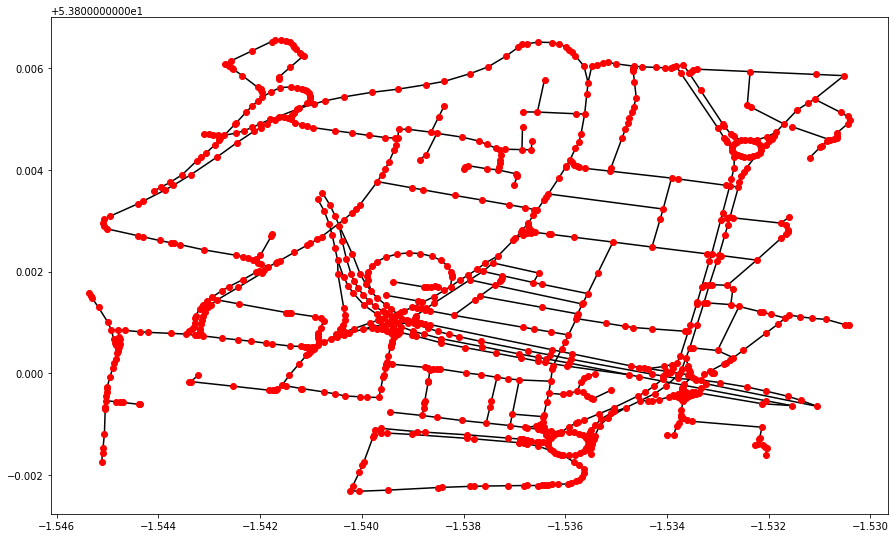

In [134]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [135]:
nodes_df

,id,geometry,comp_label
0,0,POINT (-1.53604 53.79839),0
1,1,POINT (-1.53608 53.79840),0
2,2,POINT (-1.53614 53.79841),0
3,3,POINT (-1.53619 53.79843),0
4,4,POINT (-1.53624 53.79846),0
...,...,...,...
994,994,POINT (-1.53639 53.79781),0
995,995,POINT (-1.53920 53.80107),0
996,996,POINT (-1.53907 53.80103),0
997,997,POINT (-1.53934 53.80113),0


In [138]:
# We will now snap the Soho located crimes we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(accident_points, 'accidents')
print("run bitch")
# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["crimes"].snapped_coordinates[0]
))

KeyboardInterrupt: 